In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()
import scipy.signal
import scipy.stats as stats
import statsmodels as sm
from tqdm import tnrange, tqdm_notebook
from astropy.stats import freedman_bin_width
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.svm import SVC

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from matplotlib.colors import LogNorm

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [4]:
def mat_to_df(file):
    mat = loadmat(file)
    _df = pd.DataFrame(mat['data'].reshape(256,-1))
    return _df

In [ ]:
# Cargo cada sujeto P
sujetos_p = []
for i in tnrange(1, 11):
    sujetos_p.append(mat_to_df('tp2_dataset/P{}.mat'.format(str(i).zfill(2))))

In [ ]:
# Cargo cada sujeto S
sujetos_s = []
for i in tnrange(1, 11):
    sujetos_s.append(mat_to_df('tp2_dataset/S{}.mat'.format(str(i).zfill(2))))

In [7]:
def welch_prom_canales(df, graficar=True):
    pxx_prom = pd.DataFrame()
    for i in range(0, len(df)):
        f, pxx = scipy.signal.welch(df.loc[i], fs = 250, nperseg = 201, noverlap = None)
        pxx_prom = pxx_prom.append(pd.Series(pxx), ignore_index = True)
    if graficar:
        plt.plot(f, pxx_prom.mean(axis=0))
        plt.xlim(0, 50)
        plt.show()
    return f, pxx_prom.mean(axis = 0)

def get_band(df, low, high):
    f, prom = welch_prom_canales(df, False)
    return np.sum(prom[(f >= low)&(f< high)])

def get_all_bands(sujetos):
    delta, theta, alpha, beta, gamma = [0,4], [4,8], [8, 13], [13, 30], [30, 45]
    deltas, thetas, alphas, betas, gammas = [list() for i in range(5)]
    for i in tnrange(len(sujetos)):
        deltas.append(get_band(sujetos[i], *delta))
        thetas.append(get_band(sujetos[i], *theta))
        alphas.append(get_band(sujetos[i], *alpha))
        betas.append(get_band(sujetos[i], *beta))
        gammas.append(get_band(sujetos[i], *gamma))
    return deltas, thetas, alphas, betas, gammas

def get_band_from_epoch(df, low, high):
    '''df es un DataFrame con la información de un epoch (un solo electrodo)
       devolvemos la potencia de esa banda (float)
    '''
    f, pxx = scipy.signal.welch(df, fs = 250, nperseg = 201, noverlap = None)
    return np.sum(pxx[(f >= low)&(f< high)])

def get_band_power_per_epoch(electrodo):
    '''Dado un electrodo
    '''
    delta, theta, alpha, beta, gamma = [0,4], [4,8], [8, 13], [13, 30], [30, 45]
    deltas, thetas, alphas, betas, gammas = [list() for i in range(5)]
    for i in tnrange(0, len(electrodo), 201):
        epoch = electrodo.loc[i:i+201]
        deltas.append(get_band_from_epoch(epoch, *delta))
        thetas.append(get_band_from_epoch(epoch, *theta))
        alphas.append(get_band_from_epoch(epoch, *alpha))
        betas.append(get_band_from_epoch(epoch, *beta))
        gammas.append(get_band_from_epoch(epoch, *gamma))
    return deltas, thetas, alphas, betas, gammas

def get_band_power_normalized_per_epoch(deltas, thetas, alphas, betas, gammas):
    deltas_norm, thetas_norm, alphas_norm, betas_norm, gammas_norm = [list() for i in range(5)]
    for i in tnrange(len(deltas)):
        suma = deltas[i] + thetas[i] + alphas[i] + betas[i] + gammas[i]
        deltas_norm.append(deltas[i]/suma)
        thetas_norm.append(thetas[i]/suma)
        alphas_norm.append(alphas[i]/suma)
        betas_norm.append(betas[i]/suma)
        gammas_norm.append(gammas[i]/suma)
    return deltas_norm, thetas_norm, alphas_norm, betas_norm, gammas_norm


def entropia_intra_electrodo(electrodo):
    ''' Recibe un array de un electrodo y devuelve su entropia.
    '''
    # para determinar la cantidad de simbolos en un sensor, usamos freedman_bin.
    width, bins = freedman_bin_width(electrodo, return_bins=True)
    hist, _ = np.histogram(electrodo, bins=bins)
    probas = [x/hist.sum() for x in hist]
    return stats.entropy(probas)

def entropia_intra_electrodo_per_epoch(electrodo):
    res = []
    for i in tnrange(0, len(electrodo), 201):
        epoch = electrodo.loc[i:i+201]
        res.append(entropia_intra_electrodo(epoch))
    return res

def entropia_inter_electrodo(electrodo1, electrodo2):
    # para determinar la cantidad de simbolos en un sensor, usamos freedman_bin.
    width, bins = freedman_bin_width(electrodo1 + electrodo2, return_bins=True)
    
    hist, xedges = np.histogram([(electrodo1.iloc[i],electrodo2.iloc[i]) for i in range(min(len(electrodo1), len(electrodo2)))], bins=bins)
    probas = [x/hist.sum() for x in hist]
    return stats.entropy(probas)

def entropia_inter_electrodo_per_epoch(electrodo1, electrodo2):
    res = []
    for i in tnrange(0, len(electrodo1), 201):
        epoch1 = electrodo1.loc[i:i+201]
        epoch2 = electrodo2.loc[i:i+201]
        res.append(entropia_inter_electrodo(epoch1, epoch2))
    return res

In [21]:
def graficar_roc(df, nombre_columna):
    fpr, tpr, thresholds = roc_curve(df['Grupo'].cat.codes, df[nombre_columna])
    auc_score = roc_auc_score(df['Grupo'].cat.codes, df[nombre_columna])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(nombre_columna)
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def fit_log(variable):
    X_ = X[variable].reshape(-1,1)
    log_reg = LogisticRegression()
    log_reg.fit(X_, y)

    preds = log_reg.predict(X_)
    pred_prob = log_reg.predict_proba(X_)
    
    print(confusion_matrix(y, preds))
    print(classification_report(y, preds))
    print(roc_auc_score(y, preds))
    print(cross_val_score(log_reg, X_, y))
    fpr, tpr, thresholds = roc_curve(y, pred_prob[:,0])
    auc_score = roc_auc_score(y, pred_prob[:,0])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Media y desvio por banda, y por banda norm

In [ ]:
## Entropia inter e intra electrodo

In [24]:
def fit_svm(X, y):
    mdl = SVC(probability=True)
    mdl.fit(X, y)
    preds = mdl.predict(X)
    pred_prob = mdl.predict_proba(X)
    print(confusion_matrix(y, preds))
    print(classification_report(y, preds))
    print(roc_auc_score(y, preds))
    
    fpr, tpr, thresholds = roc_curve(y, pred_prob[:,1])
    auc_score = roc_auc_score(y, pred_prob[:,1])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

[[10  0]
 [ 3  7]]
             precision    recall  f1-score   support

          0       0.77      1.00      0.87        10
          1       1.00      0.70      0.82        10

avg / total       0.88      0.85      0.85        20

0.85


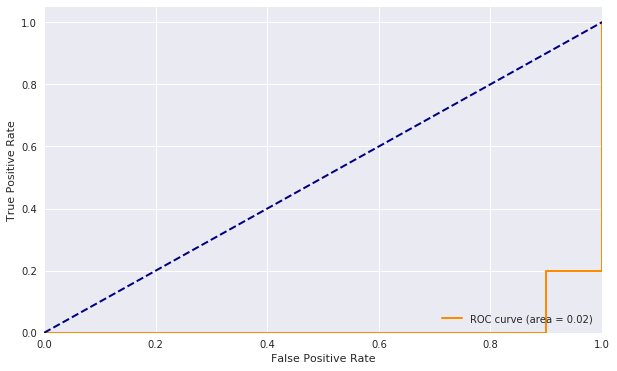

In [25]:
fit_svm(X,y)
# The plot is upside down!? xD

In [39]:
def fit_pipeline(X,y, percentile=10):
    pipe = make_pipeline(StandardScaler(),
                    SelectPercentile(percentile=percentile),
                     SVC(probability=True))
    pipe.fit(X, y)
    preds = pipe.predict(X)
    pred_prob = pipe.predict_proba(X)
    print(confusion_matrix(y, preds))
    print(classification_report(y, preds))
    print(roc_auc_score(y, preds))
    
    fpr, tpr, thresholds = roc_curve(y, pred_prob[:,1])
    auc_score = roc_auc_score(y, pred_prob[:,1])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    

[[ 8  2]
 [ 0 10]]
             precision    recall  f1-score   support

          0       1.00      0.80      0.89        10
          1       0.83      1.00      0.91        10

avg / total       0.92      0.90      0.90        20

0.9


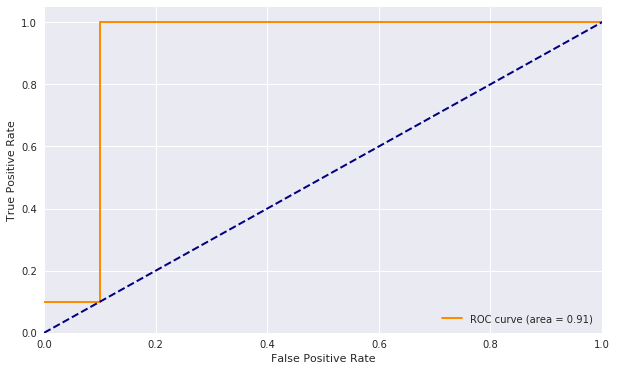

In [40]:
fit_pipeline(X,y)

[[ 8  2]
 [ 0 10]]
             precision    recall  f1-score   support

          0       1.00      0.80      0.89        10
          1       0.83      1.00      0.91        10

avg / total       0.92      0.90      0.90        20

0.9


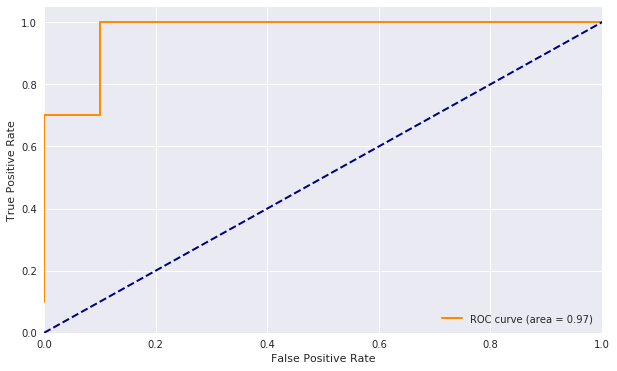

[[ 8  2]
 [ 0 10]]
             precision    recall  f1-score   support

          0       1.00      0.80      0.89        10
          1       0.83      1.00      0.91        10

avg / total       0.92      0.90      0.90        20

0.9


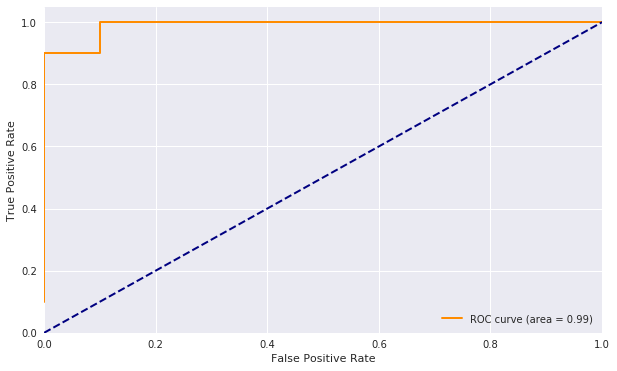

In [41]:
fit_pipeline(X, y, 20)
fit_pipeline(X, y, 35)

Al incrementar la cantidad de features, vemos que mejora la precision.